# Compute the AIC

In [11]:
import numpy as np               # sum, log, pi
import matplotlib.pyplot as plt  # plotting
from scipy import stats          # compute p-values from chi2 and Ndof
from scipy.stats import norm     # defining fit functions
from scipy.integrate import quad # compute pdf
import pandas as pd              # read data
from iminuit import Minuit       # fitting
from Module_241021 import (load_data_w_glob)
import os, sys 
sys.path.append('/Users/siljaxianpallisgaardsvendsen/Documents/KU_K/8_AppStat/AppStat2023')
from ExternalFunctionsNew import Chi2Regression # chi2 minimisation

## Functions

In [15]:
def skewed_gaussian(x, N, mu, sigma, alpha):
    Norm = N*binwidth/np.sqrt(2.0*np.pi)/sigma
    z = (x-mu)/sigma
    gaussian = Norm*np.exp(-0.5*z**2)
    cdf_gaussian = norm.cdf(alpha*z)
    return 2*gaussian*cdf_gaussian

def double_skewed_gaussian(x,
                           N1, mu1, sigma1, alpha1,
                           N2, mu2, sigma2, alpha2
                          ):
    return skewed_gaussian(x, N1, mu1, sigma1, alpha1)+skewed_gaussian(x, N2, mu2, sigma2, alpha2)


def skewed_gaussian_log_likelihood(fit_params, counts, bin_centers):

    N, mu, sigma, alpha = fit_params
    
    predicted_values = skewed_gaussian(bin_centers, N, mu, sigma, alpha)
    
    # normalise such that the sum of pdf_values = 1.
    pdf_values = predicted_values/np.sum(predicted_values)
    
    log_likelihood = np.sum(np.log(pdf_values))
    
    return log_likelihood

def double_skewed_gaussian_log_likelihood(fit_params, counts, bin_centers):
    N1, mu1, sigma1, alpha1, N2, mu2, sigma2, alpha2 = fit_params
    
    predicted_values = double_skewed_gaussian(bin_centers,
                                        N1, mu1, sigma1, alpha1,
                                        N2, mu2, sigma2, alpha2)
    
    pdf_values = predicted_values/np.sum(predicted_values) # probably not the proper way...
    
    log_likelihood = np.sum(np.log(pdf_values))
    return log_likelihood

def akaiki_information_criterion(k, log_likelihood):
    """
    Returns Akaiki Information Criterion
    AIC = 2*k - 2*ln(L)
    
    Input:
    -------
    k: number of fit parameters
    log_likelihood: np.sum(np.log(pdf_values))
    """
    return 2*k - 2*log_likelihood



def nice_string_text(x,y, minuit_obj, entries, fit_color, fitfunc, aic,font_size_text=12, ax=None):
    '''
    x, y: figure position of string (left lower corner)
    fitfunc: "string"
    aic  = Akeiki Information Criterion
    '''

    #fit information dictionary
    chi2_obj_value = minuit_obj.fval 
    Ndof_obj_value = len(bin_centers[select]) - minuit_obj.nfit
    Prob_obj_value = stats.chi2.sf(chi2_obj_value, Ndof_obj_value) # The chi2 probability given N_DOF degrees of freedom
    
    #print(Prob_obj_value)
    
    fit_info = (
        f"Entries: {entries}\n"
        f"Chi2/ Ndof: {chi2_obj_value:.2f}/ {Ndof_obj_value}\n"
        f"Prob(Chi2, Ndof): {Prob_obj_value:.2f}\n"
        f"AIC: {np.around(aic,1)}"
    )
        
        


    # fit parameter dictionary
    params_dict = {param: (minuit_obj.values[param], minuit_obj.errors[param])
                   for param in minuit_obj.parameters}

    # Format it into a multi-line string
    fit_params = "\n".join(fr"{key} = {value:.1f} $\pm$ {error:.1f}"
                               for key, (value, error) in params_dict.items())

    # join text
    formatted_text = fitfunc+":\n" + fit_info + "\n" + fit_params


    # Plot and display the text on the figure
    if ax==None:
        fig, ax=plt.subplots(figsize=(5,5))
    else:
        ax=ax
        ax.text(x, y, formatted_text, fontsize=font_size_text, transform=plt.gca().transAxes, color=fit_color)

# Fit the data
Get fit parameters

In [13]:
# read data
diff_tau_all = pd.read_csv("time_delay_diff_241021.csv")

Nbins 33 bindwidth 1.0


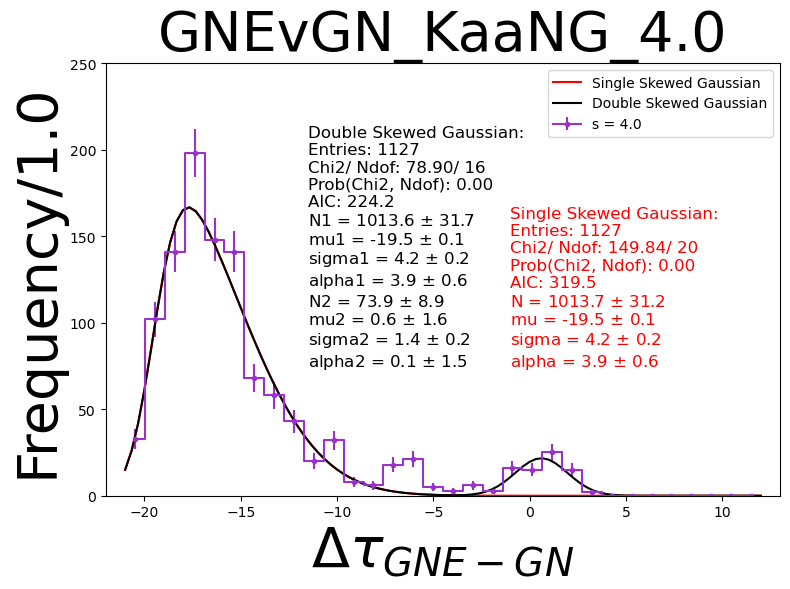

In [30]:
# select data
dataframe=diff_tau_all
network="GNEvGN"
parameter="KaaNG"
date="281124"
scalefactor=4.0
data_color="darkorchid"#"cornflowerblue"#"grey"#"darkorchid"#"darkorange"
font_size=40

mask0 = dataframe["two_networks"]==network
mask1 = dataframe["parameter"]==parameter
mask2 = dataframe["rel change"]==scalefactor

sample = dataframe[mask0 & mask1 & mask2]["time diff"]

Nbins = int(np.sqrt(len(sample))) # 33
binwidth = ((12-(-21))/float(Nbins))#(max(sample)-min(sample))/float(Nbins)
print("Nbins",Nbins, "bindwidth", binwidth)


# PREPARE DATA FOR FITTING
binning = np.linspace(-21, 12, Nbins)
counts, bin_edges = np.histogram(sample, bins=binning)


unc_counts = np.sqrt(counts)
bin_centers = bin_edges[:-1]+(bin_edges[1]-bin_edges[0])/2
select = counts > 0


# PLOT DATA
# as aid to set initial guesses
fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(bin_centers, counts, yerr=unc_counts,
            marker=".", drawstyle="steps-mid",color=data_color,
            label=f"s = {scalefactor}"
           )
ax.set_title(f"{network}_{parameter}_{scalefactor}", fontsize=font_size)
ax.set_xlabel(r"$\Delta\tau_{GNE-GN}$", fontsize=font_size)
ax.set_ylabel(f"Frequency/{np.around(binwidth,1)}", fontsize=font_size)
plt.legend(fontsize=20, loc="upper right")



# SINGLE SKEWED GAUSSIAN

# chi2 fit
chi2_single_peak = Chi2Regression(skewed_gaussian, bin_centers[select], counts[select], unc_counts[select])
minuit_obj_single_peak = Minuit(chi2_single_peak,
                                N=200, mu=-17.0, sigma=4.0, alpha=4.0
                               )
minuit_obj_single_peak.errordef=1.0 # chi2 fit
minuit_obj_single_peak.migrad()     # run minimisation

# AIC
log_likelihood_single_peak = skewed_gaussian_log_likelihood(fit_params=minuit_obj_single_peak.values[:],
                                                            counts=counts[select],
                                                            bin_centers=bin_centers[select]
                                                           )
AIC_single_peak = akaiki_information_criterion(k=len(minuit_obj_single_peak.values[:]),
                                               log_likelihood=log_likelihood_single_peak
                                              )

# DOUBLE SKEWED GAUSSIAN

# chi2 fit
chi2_double_peak = Chi2Regression(double_skewed_gaussian, bin_centers[select], counts[select], unc_counts[select])
minuit_obj_double_peak = Minuit(chi2_double_peak,
                                N1=200, mu1=-17.0, sigma1=4.0, alpha1=4.0,
                                N2=30, mu2=3.0, sigma2=2.0, alpha2=0.0
                               )

minuit_obj_double_peak.errordef=1.0 # chi2 fit
minuit_obj_double_peak.migrad()     # run minimisation

# AIC
log_likelihood_double_peak = double_skewed_gaussian_log_likelihood(fit_params=minuit_obj_double_peak.values[:],
                                                                  counts=counts[select],
                                                                  bin_centers=bin_centers[select])
AIC_double_peak = akaiki_information_criterion(k=len(minuit_obj_double_peak.values[:]),
                                               log_likelihood=log_likelihood_double_peak
                                              )

# PLOT FITS
x = np.linspace(-21, 12, 100)
ax.plot(x, skewed_gaussian(x, *minuit_obj_single_peak.values[:]),
       color="red", label="Single Skewed Gaussian")
ax.plot(x, double_skewed_gaussian(x, *minuit_obj_double_peak.values[:]),
       color="black", label="Double Skewed Gaussian"
       )

# FIT DATA
nice_string_text(x=0.6, y=0.3, minuit_obj=minuit_obj_single_peak, entries=len(sample), aic=AIC_single_peak,
                 fit_color="red", fitfunc="Single Skewed Gaussian",font_size_text=12, ax=ax)
nice_string_text(x=0.3, y=0.3, minuit_obj=minuit_obj_double_peak, entries=len(sample), aic=AIC_double_peak,
                 fit_color="black", fitfunc="Double Skewed Gaussian",font_size_text=12,ax=ax)

plt.legend()


# FIGURE ADJUSTMENTS + SAVE
ax.set_xlim(-22, 13)
ax.set_ylim(0,250)
plt.tight_layout()
plt.savefig(f"{network}_{parameter}_{scalefactor}_{date}.pdf", dpi=600)